# Network features and questions 

Here we aim to use network science techniques to answer our questions about politics and voting patterns. The network construction was realized in the two previous notebooks. 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import community 
import pygraphviz as pgv 

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import time
from tqdm.notebook import trange, tqdm
import json
from collections import defaultdict

import sys  
sys.path.insert(0, '../pyscripts/')

from prepare_adjacency_matrix import GraphConstruction

## Notebook settings

Below we define some things important all over the notebook. 

In [2]:
party_color = {'PT': '#CC0000', 'PSL': '#008000', 'PL': '#0F0073', 'PP': '#7DC9FF',
               'PSDB': '#0080FF', 'PSD':'#FFA500', 'MDB': '#30914D', 'REPUBLICANOS': '#005DAA', 
               'PSB': '#FFCC00', 'DEM': '#8CC63E', 'PDT': '#FF0000', 'SOLIDARIEDADE': '#FF9C2B', 
               'PROS': '#FF5460', 'PODE': '#2DA933', 'PTB': '#7B7B7B', 'PSC': '#009118', 
               'PSOL': '#700000', 'PCdoB': '#A30000', 'CIDADANIA': '#EC008C', 'AVANTE': '#ED5F36', 
               'NOVO': '#FF4D00', 'PATRIOTA': '#00A29B', 'PV': '#006600', 'REDE': '#379E8D', 
               'S.PART.': '#DDDDDD', 'PR': '#0F0073', 'PRB': '#005DAA', 'PATRI': '#00A29B', 
               'PHS': 'black', 'PPS': '#EC008C', 'PPL': 'black', 'PRTB': 'black', 'PRP': 'black',
               'PMDB': '#30914D', 'PP**': "#7DC9FF", 'SDD': '#FF9C2B', 'PMN': 'black', 'PTdoB': '#ED5F36',
               'PTC': 'black', 'PFL': '#8CC63E', 'PL*': '#0F0073', 'PEN': '#00A29B','PSDC': 'black'
              }

region_color = {'Norte': '#08FB74', 'Nordeste': '#FA9A14', 'Sudeste': '#6E30FF', 
                'Sul': '#E61C38', 'Centro-oeste': '#D7E307'}

palette = "#21593b"

sns.set()
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)
%matplotlib inline

def get_graph(legislature, metric = ('same','same'), threshold = 0.95):
    
    adjacency_matrix = graphConstrutor.import_adjacency_matrix(legislature, *metric)
    G = graphConstrutor.build_graph_threshold(adjacency_matrix, legislature = legislature,
                                          threshold = threshold)

    # Removing the zero-degree deputies. 
    remove = [node for node,degree in dict(G.degree()).items() if degree < 1]
    G.remove_nodes_from(remove)

    # For Networkx, it is better to work with consecutive integers. 
    # For that, we do this simple transformation. 
    G = nx.convert_node_labels_to_integers(G, first_label = 0, ordering = 'default', label_attribute = 'id')
    
    return G

def plotting_graph(G, color_dict, color_type, legislature):

    # Setting up colors 
    colors = [color_dict[G.nodes[n][color_type]] for n in G.nodes]

    fig, ax = plt.subplots(figsize=(20,10))

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos=pos, node_size = 50, node_color = colors, ax = ax)
    nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

    for label,color in color_dict.items():
        ax.plot([0],[0], color=color, label=label)

    ax.legend()
    plt.title('Legislature {}'.format(legislature), fontsize = 20)
    plt.show()

The object to build the graphs. 

In [3]:
graphConstrutor = GraphConstruction()

## Measures and characteristics of the network 

Below we observe some of the main characteristics of the network using the measures from graph theory. They also allow us to compare with the traditional models. 

### Number of nodes and edges

In [4]:
number_nodes = []
number_edges = []
number_zero_degree = []
average_path = []
assortativity_coef = []
assortativity_coef_party = []
assortativity_coef_region = []

for legislature in trange(52, 57): 

    G = get_graph(legislature)
    number_nodes.append((legislature, G.number_of_nodes()))
    number_edges.append((legislature, G.number_of_edges()))
    number_zero_degree.append((legislature, sum(np.array(G.degree())[:,1] < 1)))
    average_path.append((legislature, nx.average_shortest_path_length(G)))
    assortativity_coef.append((legislature, nx.degree_assortativity_coefficient(G)))
    assortativity_coef_party.append((legislature, nx.attribute_assortativity_coefficient(G, 'party')))
    assortativity_coef_region.append((legislature, nx.attribute_assortativity_coefficient(G, 'region')))

  0%|          | 0/5 [00:00<?, ?it/s]

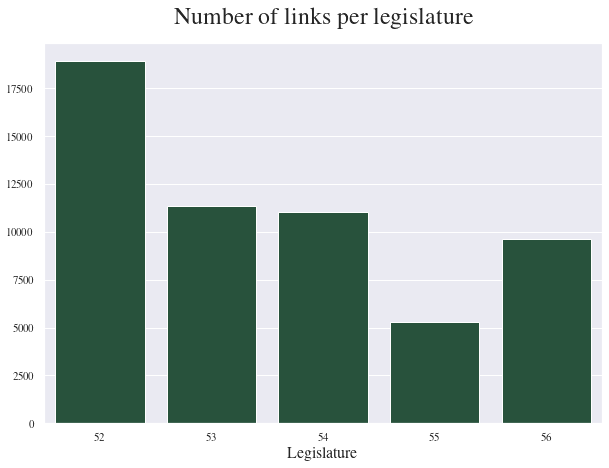

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


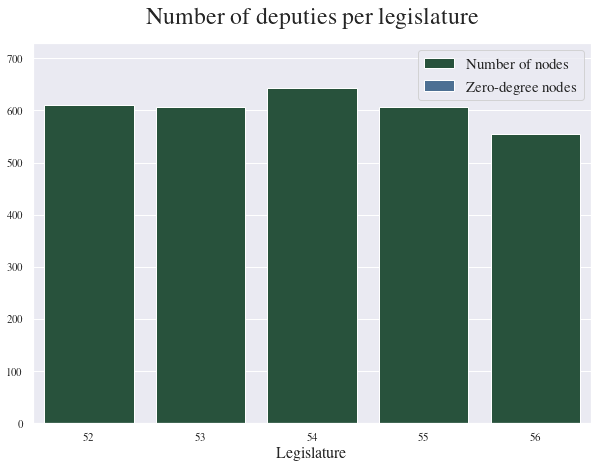

In [5]:
fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(x = [i[0] for i in number_edges], 
            y = [i[1] for i in number_edges], 
            color = "#21593b", ax = ax,
            label='')

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Number of links per legislature', fontsize = 24, pad = 20)

plt.show()

fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(x = [i[0] for i in number_nodes], 
            y = [i[1] for i in number_nodes], 
            color = "#21593b", ax = ax,
            label='Number of nodes')

sns.barplot(x = [i[0] for i in number_zero_degree], 
            y = [i[1] for i in number_zero_degree], 
            color = "#41709f", ax = ax, 
            label='Zero-degree nodes')

ax.legend(loc = 'upper right', fontsize = 15)
ax.set_ylim((0,730))

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Number of deputies per legislature', fontsize = 24, pad = 20)

plt.show()

## Degree distribution

How does it changes during the legislatures? 

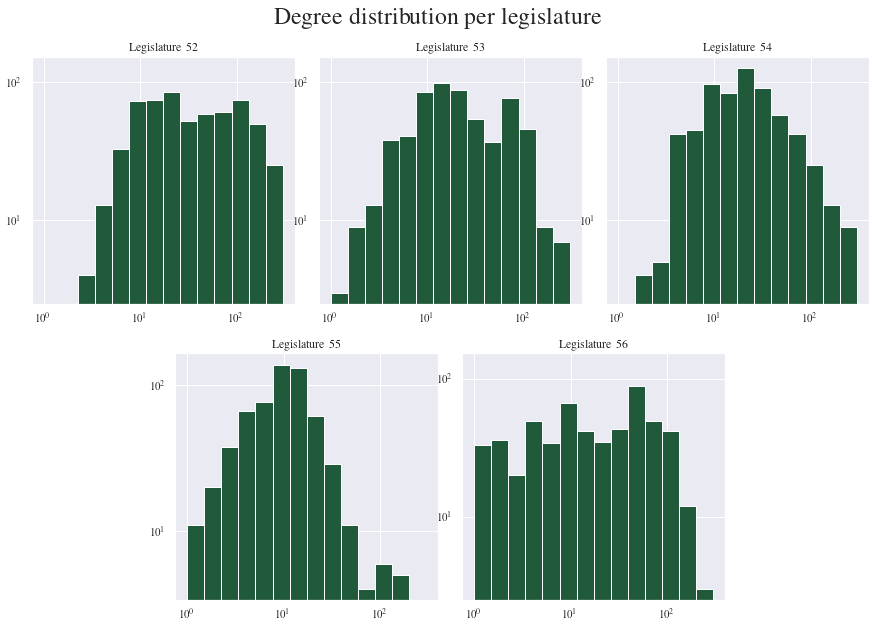

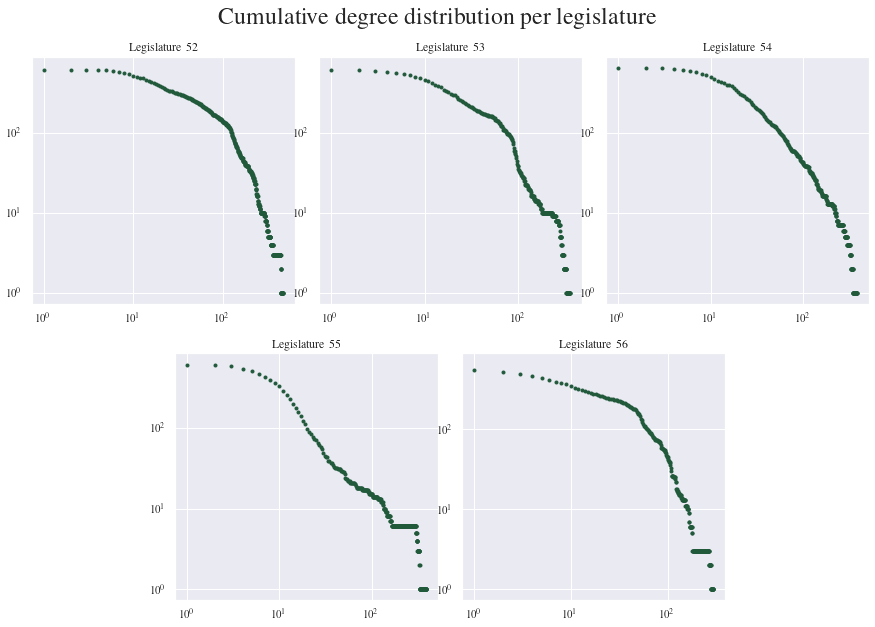

In [6]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Degree distribution per legislature', fontsize = 24, y = 0.95)
ax = []
ax.append(plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig = fig))
ax.append(plt.subplot2grid((2,6), (0,2), colspan=2, fig = fig, sharey = ax[0]))
ax.append(plt.subplot2grid((2,6), (0,4), colspan=2, fig = fig, sharey = ax[0]))
ax.append(plt.subplot2grid((2,6), (1,1), colspan=2, fig = fig))
ax.append(plt.subplot2grid((2,6), (1,3), colspan=2, fig = fig, sharey = ax[1]))

for legislature in range(52,57): 
    
    G = get_graph(legislature)
    degree_distribution = np.array(G.degree())[:,1]
        
    ax[legislature-52].hist(degree_distribution, 
                            bins = np.logspace(start=np.log10(1), stop=np.log10(300), num=15),
                            color = palette
                            )
    ax[legislature-52].set_title('Legislature {}'.format(legislature))
        
    ax[legislature-52].set_xscale('log')
    ax[legislature-52].set_yscale('log')
    
plt.show()

fig = plt.figure(figsize = (15,10))
fig.suptitle('Cumulative degree distribution per legislature', fontsize = 24, y = 0.95)
ax = []
ax.append(plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig = fig))
ax.append(plt.subplot2grid((2,6), (0,2), colspan=2, fig = fig, sharey = ax[0]))
ax.append(plt.subplot2grid((2,6), (0,4), colspan=2, fig = fig, sharey = ax[0]))
ax.append(plt.subplot2grid((2,6), (1,1), colspan=2, fig = fig))
ax.append(plt.subplot2grid((2,6), (1,3), colspan=2, fig = fig, sharey = ax[1]))

for legislature in range(52,57): 
    
    G = get_graph(legislature)
    degree_freq = np.array(nx.degree_histogram(G))[1:]
    degrees = np.array(range(1,len(degree_freq)+1))
    com_distribution = degree_freq[::-1].cumsum()[::-1]
        
    ax[legislature-52].scatter(degrees, com_distribution, 
                               marker = '.',
                               color = palette
                               )
    ax[legislature-52].set_title('Legislature {}'.format(legislature))
        
    ax[legislature-52].set_xscale('log')
    ax[legislature-52].set_yscale('log')

## Clustering coefficient

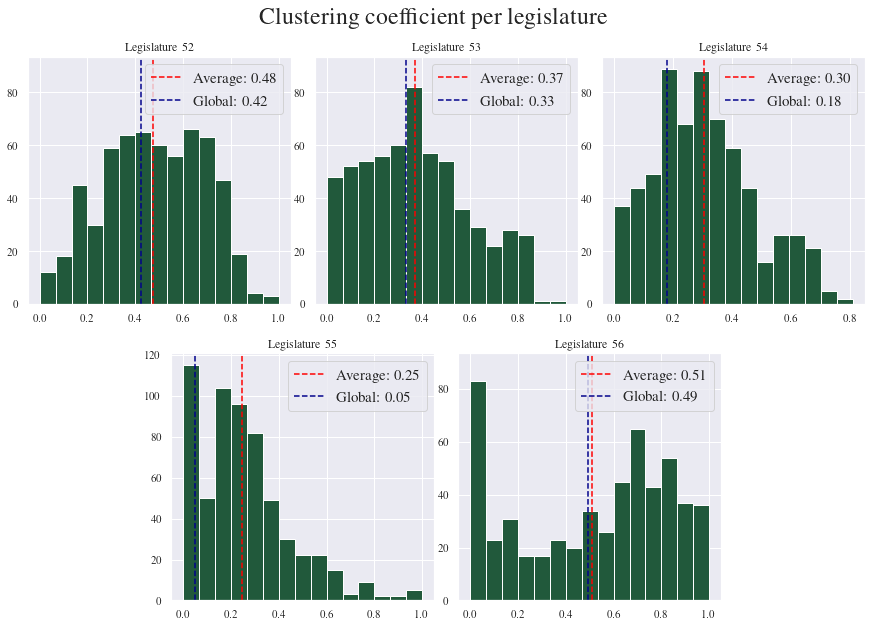

In [7]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Clustering coefficient per legislature', fontsize = 24, y = 0.95)
ax = []
ax.append(plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig = fig))
ax.append(plt.subplot2grid((2,6), (0,2), colspan=2, fig = fig, sharey = ax[0]))
ax.append(plt.subplot2grid((2,6), (0,4), colspan=2, fig = fig, sharey = ax[0]))
ax.append(plt.subplot2grid((2,6), (1,1), colspan=2, fig = fig))
ax.append(plt.subplot2grid((2,6), (1,3), colspan=2, fig = fig, sharey = ax[1]))

for legislature in range(52,57): 
    
    G = get_graph(legislature)
    cluestering_distribution = nx.clustering(G).values()
        
    ax[legislature-52].hist(cluestering_distribution, 
                            bins = 15,
                            color = palette
                            )
    v = sum(cluestering_distribution)/len(cluestering_distribution)
    ax[legislature-52].axvline(v, color = 'red', linestyle = '--', label = 'Average: {:.2f}'.format(v))
    v = nx.transitivity(G)
    ax[legislature-52].axvline(v, color = 'darkblue', linestyle = '--', label = 'Global: {:.2f}'.format(v))
    ax[legislature-52].set_title('Legislature {}'.format(legislature))
    
    ax[legislature-52].legend(loc='upper right', fontsize = 15)
    
plt.show()

## Average path length 

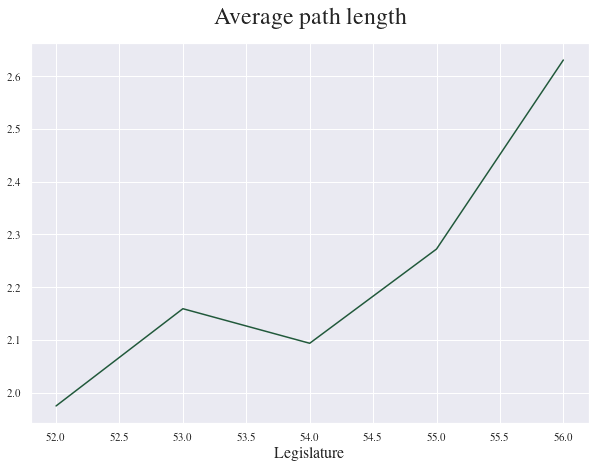

In [8]:
fig, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x = [i[0] for i in average_path], 
             y = [i[1] for i in average_path], 
             markers = ['o'],
             color = "#21593b", ax = ax,
             label='')

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Average path length', fontsize = 24, pad = 20)

plt.show()

## Degree Correlation

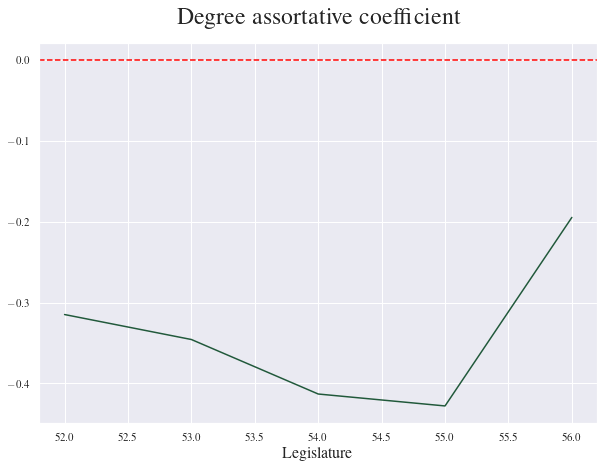

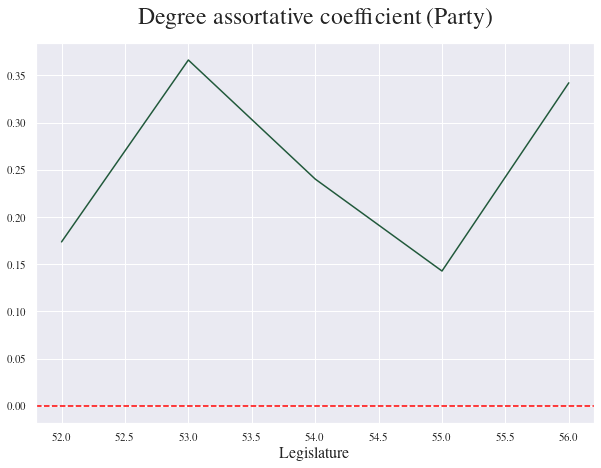

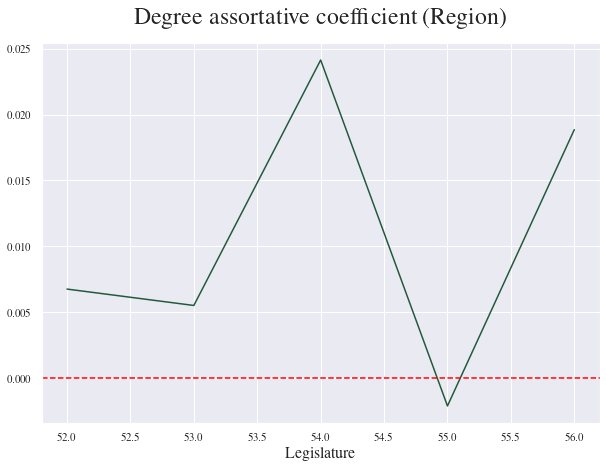

In [9]:
fig, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x = [i[0] for i in assortativity_coef], 
             y = [i[1] for i in assortativity_coef], 
             color = "#21593b", ax = ax,
             label='')

ax.axhline(0, color = 'red', linestyle = '--')

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Degree assortative coefficient', fontsize = 24, pad = 20)

plt.show()

fig, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x = [i[0] for i in assortativity_coef_party], 
             y = [i[1] for i in assortativity_coef_party], 
             color = "#21593b", ax = ax,
             label='')

ax.axhline(0, color = 'red', linestyle = '--')

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Degree assortative coefficient (Party)', fontsize = 24, pad = 20)

plt.show()

fig, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x = [i[0] for i in assortativity_coef_region], 
             y = [i[1] for i in assortativity_coef_region], 
             color = "#21593b", ax = ax,
             label='')

ax.axhline(0, color = 'red', linestyle = '--')

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Degree assortative coefficient (Region)', fontsize = 24, pad = 20)

plt.show()

## Drawing the network 

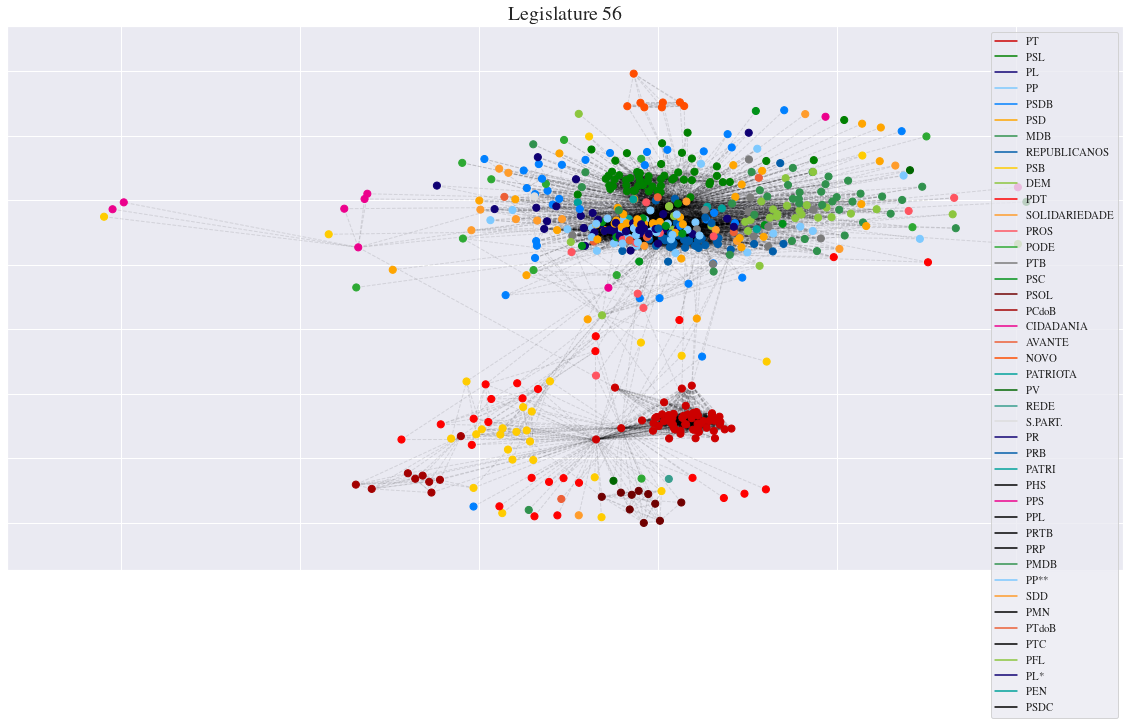

In [112]:
G = get_graph(56)
plotting_graph(G, color_dict = party_color, color_type = 'party', legislature = 56)

## Hubs

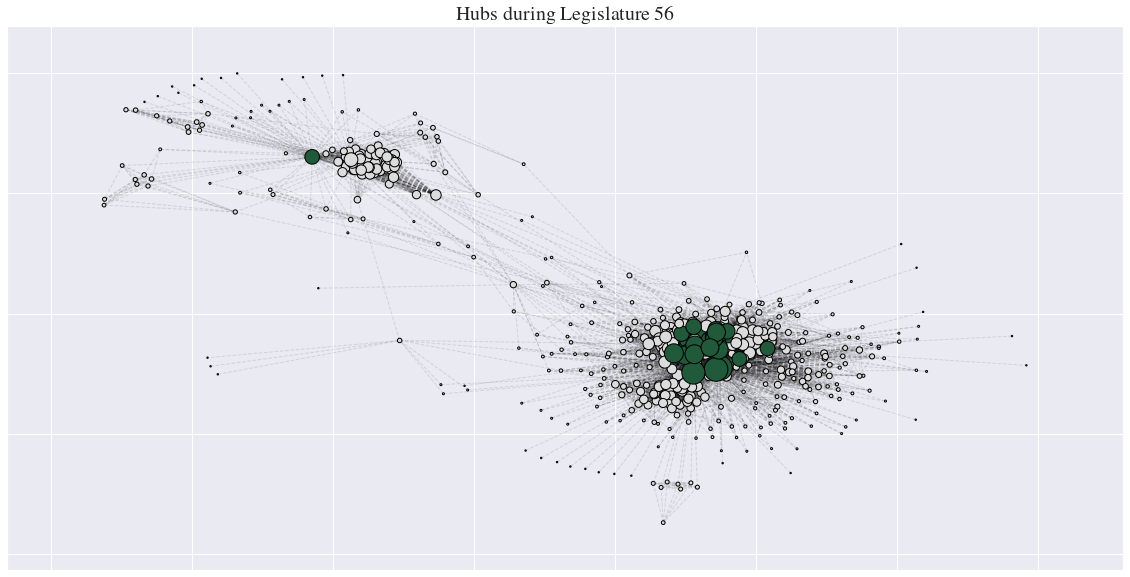

In [113]:
colors = [palette if G.degree[n] > 100 else 'gainsboro' for n in G.nodes]
sizes = np.array([G.degree[n] for n in G.nodes])

fig, ax = plt.subplots(figsize=(20,10))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size = 2*sizes, node_color = colors, ax = ax, edgecolors = 'black')
nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha = 0.1, ax = ax)

#for label,color in community_colors.items():
#    ax.plot([0],[0], color=color, label=label)

##ax.legend()
plt.title('Hubs during Legislature 56', fontsize = 20)
plt.show()

## Modularity 

Here we compare the modularity with the parties been the clusters and the optimized communities. 

In [114]:
parties_modularity = []
community_modularity = []

for legislature in trange(52, 57): 

    G = get_graph(legislature)
    
    partition_party = defaultdict(list)
    for key, val in sorted(nx.get_node_attributes(G, 'party').items()):
        partition_party[val].append(key)
    partition_party = partition_party.values()
    
    communities = community.greedy_modularity_communities(G, resolution = 1.0)
    
    parties_modularity.append((legislature, community.modularity(G, communities=partition_party)))
    community_modularity.append((legislature, community.modularity(G, communities=communities)))

  0%|          | 0/5 [00:00<?, ?it/s]

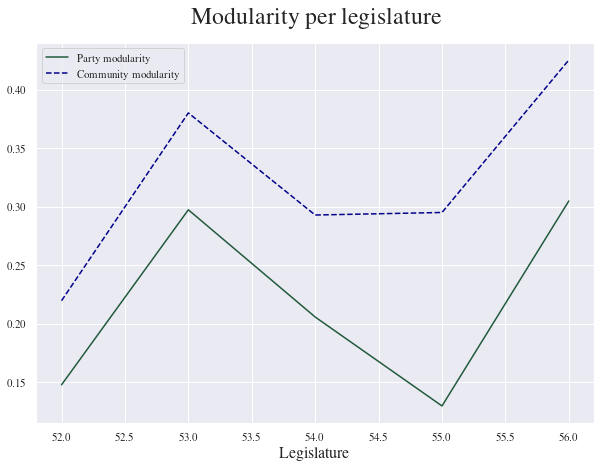

In [115]:
fig, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x = [i[0] for i in parties_modularity], 
             y = [i[1] for i in parties_modularity], 
             color = "#21593b", ax = ax,
             label='Party modularity')

sns.lineplot(x = [i[0] for i in community_modularity], 
             y = [i[1] for i in community_modularity], 
             color = "darkblue", ax = ax, linestyle = '--',
             label='Community modularity')

ax.set_xlabel('Legislature', fontsize=16)
ax.set_ylabel('')
ax.set_title('Modularity per legislature', fontsize = 24, pad = 20)

plt.show()

## Communities

Using the concept of modularity, we can use the greedy algorithm to obtain subgraphs forming communities. 

In [116]:
communities = community.greedy_modularity_communities(G, resolution = 1.0)
node_belonging = {node: v for v in range(len(communities)) for node in communities[v]}
nx.set_node_attributes(G, node_belonging, name = 'community')  

In [117]:
# Picking the colors for the communities 
def pick_colors(n, palette = 'hsv'): 
    cmap = cm.get_cmap(palette, n)
    colors = {i: matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)}
    return colors

community_colors = {0: '#3E5B8F', 
                    1: '#14D9F5', 
                    2: '#C23A23', 
                    3: '#F68151', 
                    4: '#FA3400',
                    5: '#235BC2',}

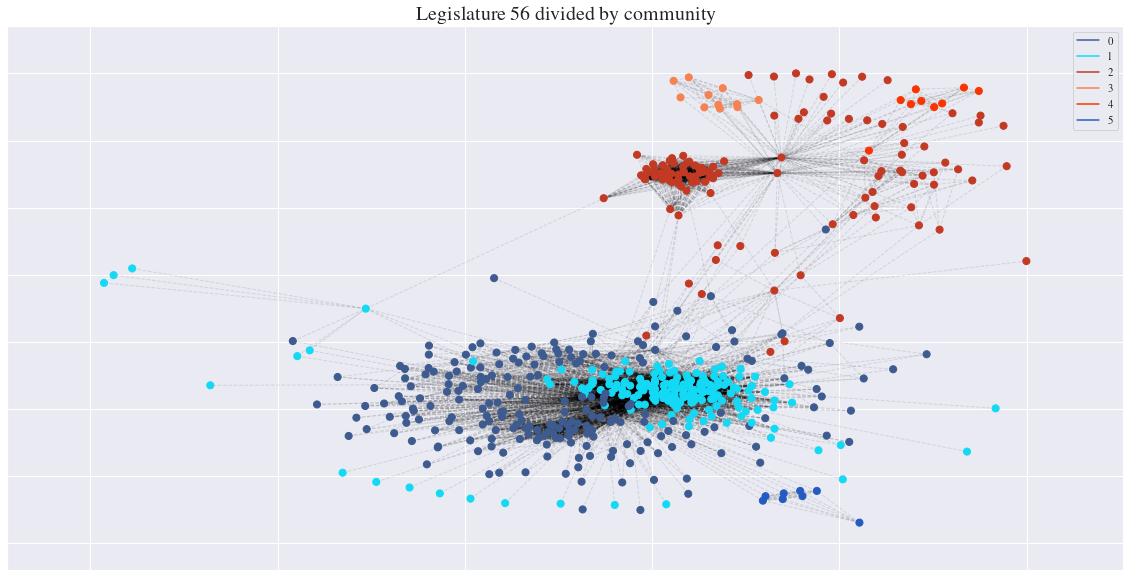

In [118]:
colors = [community_colors[G.nodes[n]['community']] for n in G.nodes]

fig, ax = plt.subplots(figsize=(20,10))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size = 50, node_color = colors, ax = ax)
nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

for label,color in community_colors.items():
    ax.plot([0],[0], color=color, label=label)

ax.legend()
plt.title('Legislature 56 divided by community', fontsize = 20)
plt.show()

And if we want to know which parties are included in each community? 

In [119]:
parties_communities = [{} for i in range(len(communities))]
for node in G.nodes: 
    
    node_attributes = G.nodes[node]
    community = node_attributes['community']
    party = G.nodes[node]['party']
    try: 
        parties_communities[community][party] += 1
    except KeyError as e:
        parties_communities[community][party] = 1
        
parties_communities = pd.DataFrame({i: parties_communities[i] for i in range(len(communities))})#.fillna(0)
number_deputies = parties_communities.sum(axis = 1)
parties_communities = parties_communities.div(number_deputies, axis = 0)
parties_communities['deputies'] = number_deputies

Note that, excluding the zeros, if we take the maximum less minimum (except when the minimum is 1) from each party, we have a measure of how concentrated it is in one community. If the party has a lot of deputies in the same community, we will see a high measure: for instance PT, REDE, NOVO, PSOL, PCdoB, PSL, MDB, etc. That means that the community algorithm is well detecting these parties. Otherwise, some parties are more distributes, which means that the proportion of deputies in different communities differs little, indicanting a non-consistency considering the voting pattern. In special, PTB has the same number of deputies in two different communities. 

In [15]:
maximum = parties_communities[list(range(6))].max(axis=1) 
minimum = parties_communities[list(range(6))].min(axis=1)

(maximum - minimum*(minimum < 1)).sort_values()

PTB              0.000000
PROS             0.272727
PATRIOTA         0.333333
CIDADANIA        0.333333
PV               0.333333
AVANTE           0.375000
SOLIDARIEDADE    0.533333
PODE             0.583333
PSC              0.600000
PSDB             0.611111
PSD              0.625000
PP               0.627907
DEM              0.677419
REPUBLICANOS     0.684211
PSB              0.777778
PL               0.826087
PDT              0.846154
MDB              0.897436
PSL              0.963636
S.PART.          1.000000
PT               1.000000
REDE             1.000000
PSOL             1.000000
PCdoB            1.000000
NOVO             1.000000
dtype: float64

## Degree distribution inside communities 

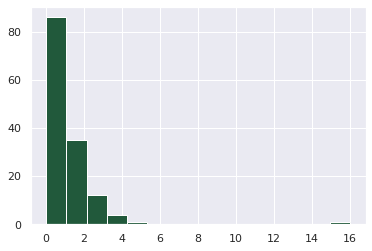

In [84]:
community_subgraph = nx.Graph(G.subgraph(communities[1]))

degree_freq = np.array(nx.degree_histogram(community_subgraph))[1:]
degrees = np.array(range(1,len(degree_freq)+1))

plt.hist(degree_freq, bins = 15, color = palette)
plt.show()

In [85]:
np.array(nx.degree(community_subgraph))[:,1].mean()

53.92553191489362

In [86]:
nx.info(community_subgraph)

'Graph with 188 nodes and 5069 edges'

The modularity of the parties is the following 

In [105]:
nodes_per_party = defaultdict(list)
for key, val in sorted(nx.get_node_attributes(G, 'party').items()):
    nodes_per_party[val].append(key)
    
community.modularity(G, nodes_per_party.values())

0.304789044911383

In [12]:
nodes_per_party = defaultdict(list)
for key, val in sorted(nx.get_node_attributes(G, 'party').items()):
    nodes_per_party[val].append(key)

## Party graph

In [151]:
number_deputies_party = list(map(lambda x: (x[0], len(x[1])), nodes_per_party.items()))

In [180]:
parties_graph = nx.Graph()

parties_graph.add_nodes_from(np.unique(list(nx.get_node_attributes(G, 'party').values())))

for edge in G.edges(): 
    party1 = G.nodes[edge[0]]['party']
    party2 = G.nodes[edge[1]]['party']
    if parties_graph.has_edge(party1, party2):
        parties_graph.edges[party1, party2].update({'weight': parties_graph.edges[party1, party2].get('weight') + 1})
    else:
        parties_graph.add_edge(party1, party2, weight = 1)

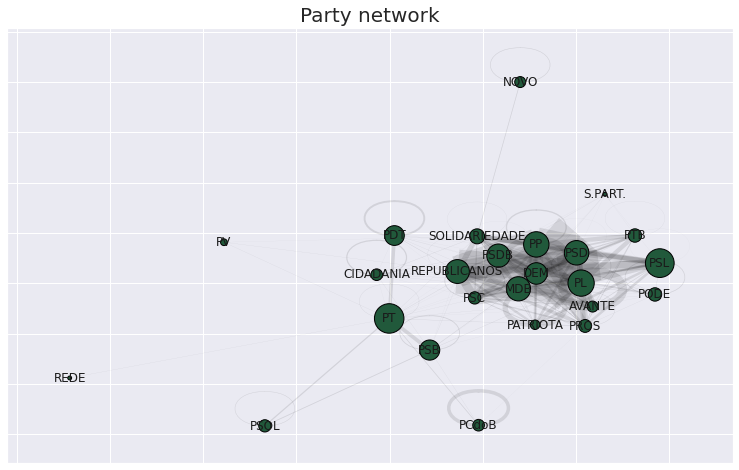

In [217]:
fig, ax = plt.subplots(figsize=(13,8))

pos = nx.spring_layout(parties_graph, weight = None)
nx.draw_networkx_nodes(parties_graph, pos=pos, node_size =  [15 * v[1] for v in number_deputies_party], 
                       nodelist =  [v[0] for v in number_deputies_party], node_color = palette, 
                       edgecolors = 'black', ax = ax)
nx.draw_networkx_edges(parties_graph, pos=pos, edge_color='black',alpha =0.1, 
                       width = 0.1*np.array([parties_graph[u][v]['weight'] for u,v in parties_graph.edges]), 
                       edgelist = parties_graph.edges,
                       ax = ax)
nx.draw_networkx_labels(parties_graph, pos = pos)

plt.title('Party network', fontsize = 20)
plt.show()

## Party distances

In [38]:
shortest_path_lengths = list(nx.shortest_path_length(G))

distances = pd.DataFrame([shortest_path_lengths[i][1] for i in range(G.number_of_nodes())], 
                         index = [shortest_path_lengths[i][0] for i in range(G.number_of_nodes())])
distances = distances[range(0,G.number_of_nodes())]

In [90]:
party_distances1 = pd.DataFrame(np.zeros((len(nodes_per_party.keys()), len(nodes_per_party.keys()))), 
                               columns = nodes_per_party.keys(),
                               index = nodes_per_party.keys())

party_distances2 = pd.DataFrame(np.zeros((len(nodes_per_party.keys()), len(nodes_per_party.keys()))), 
                               columns = nodes_per_party.keys(),
                               index = nodes_per_party.keys())

for party1 in party_distances:
    for party2, _ in party_distances.iterrows():
        df_dist = distances.loc[nodes_per_party[party1], nodes_per_party[party2]]
        party_distances1.loc[party1, party2] = df_dist.sum().sum()/(df_dist.shape[0]*df_dist.shape[1])   # Mean metric
        party_distances2.loc[party1, party2] = max(df_dist.min().max(), df_dist.transpose().min().max()) # Hausdorff distance

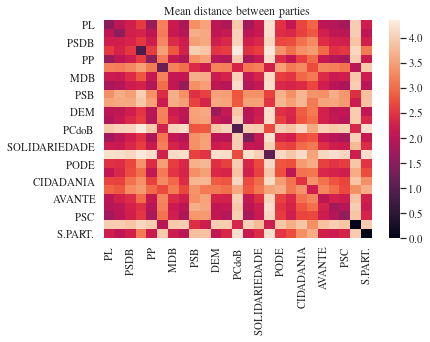

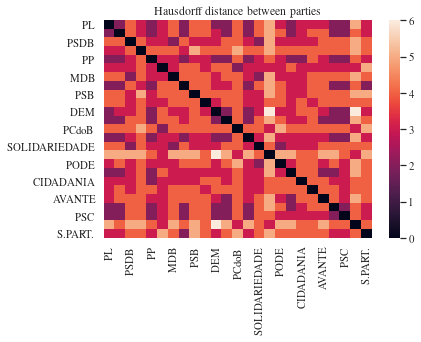

In [92]:
sns.heatmap(party_distances1)
plt.title('Mean distance between parties')
plt.show()
sns.heatmap(party_distances2)
plt.title('Hausdorff distance between parties')
plt.show()